In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np

import matplotlib.dates as mdates

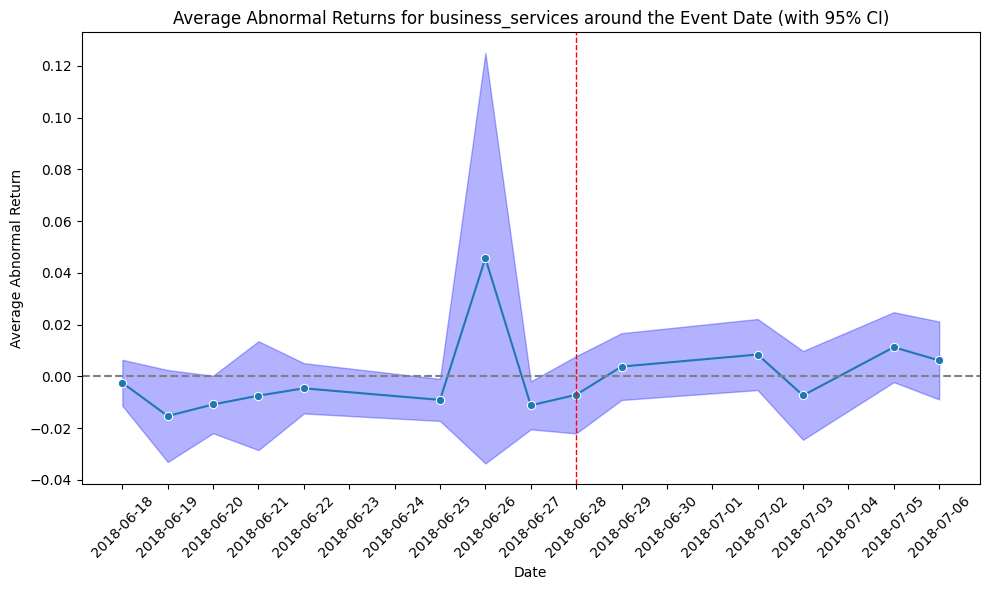

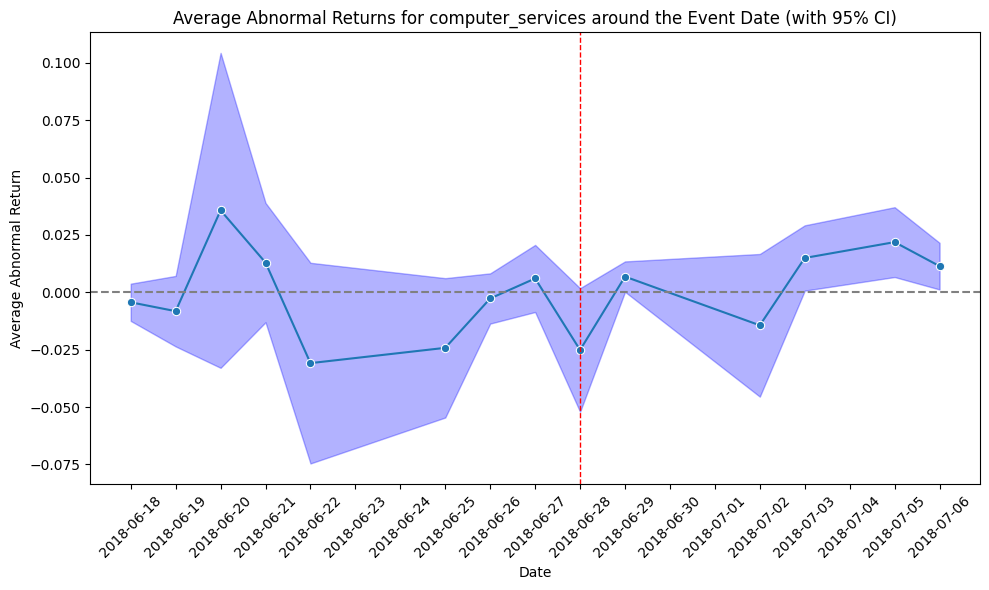

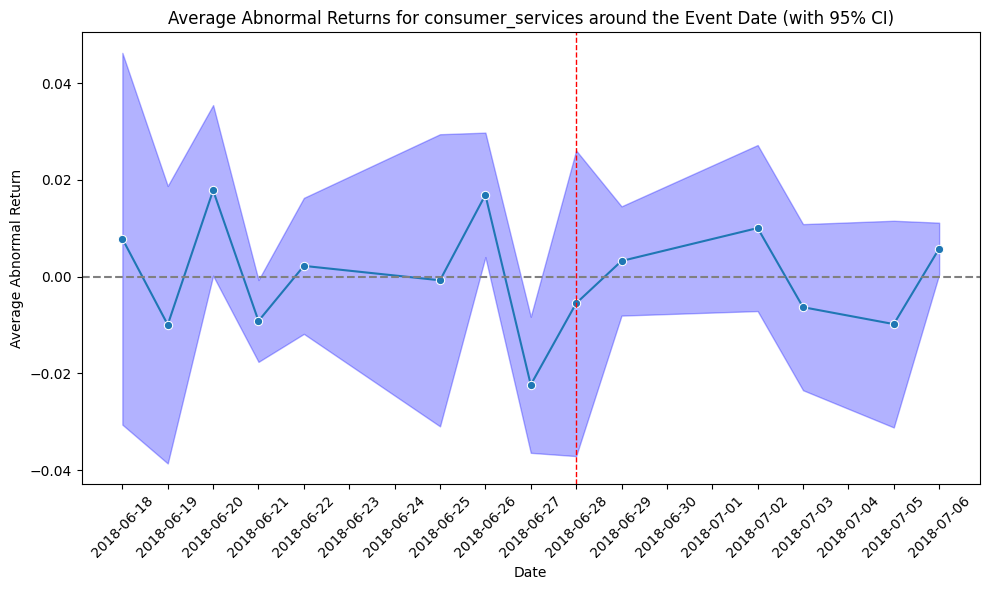

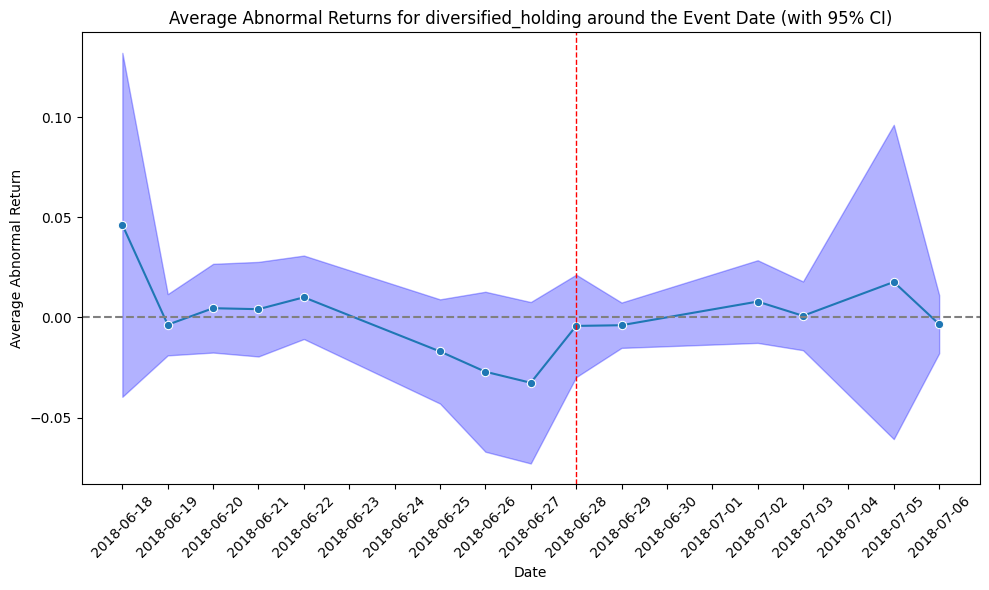

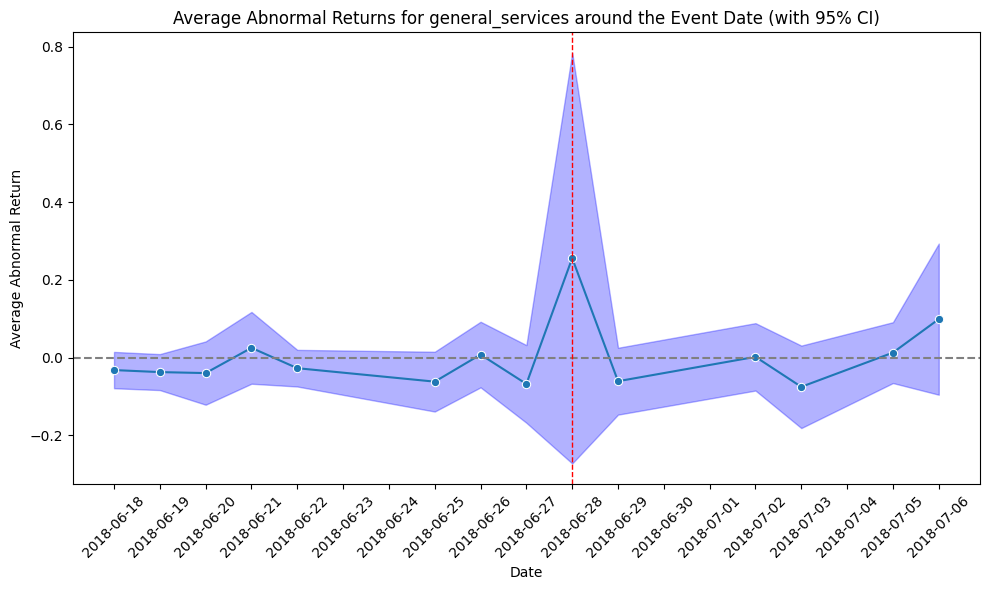

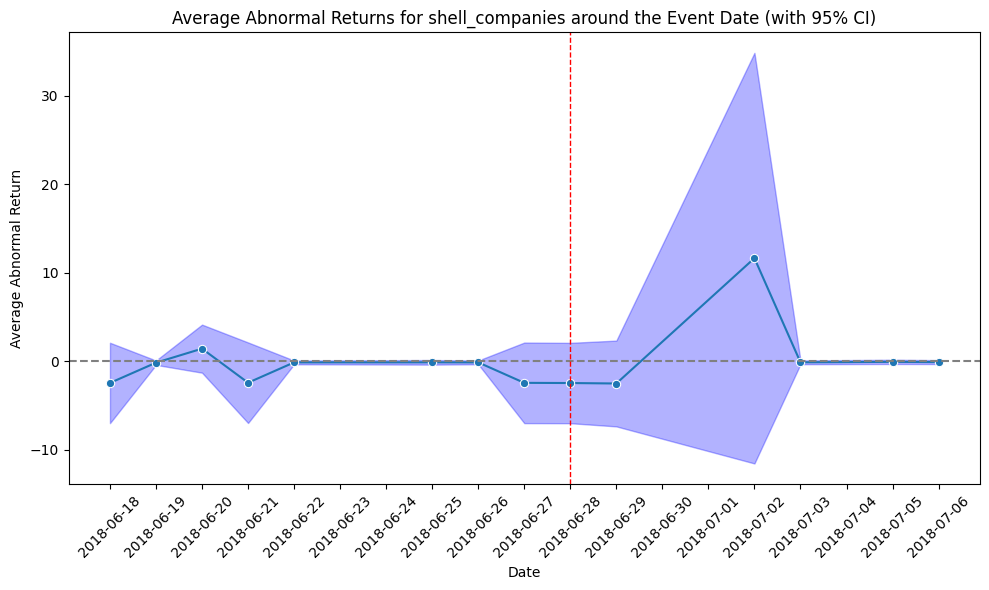

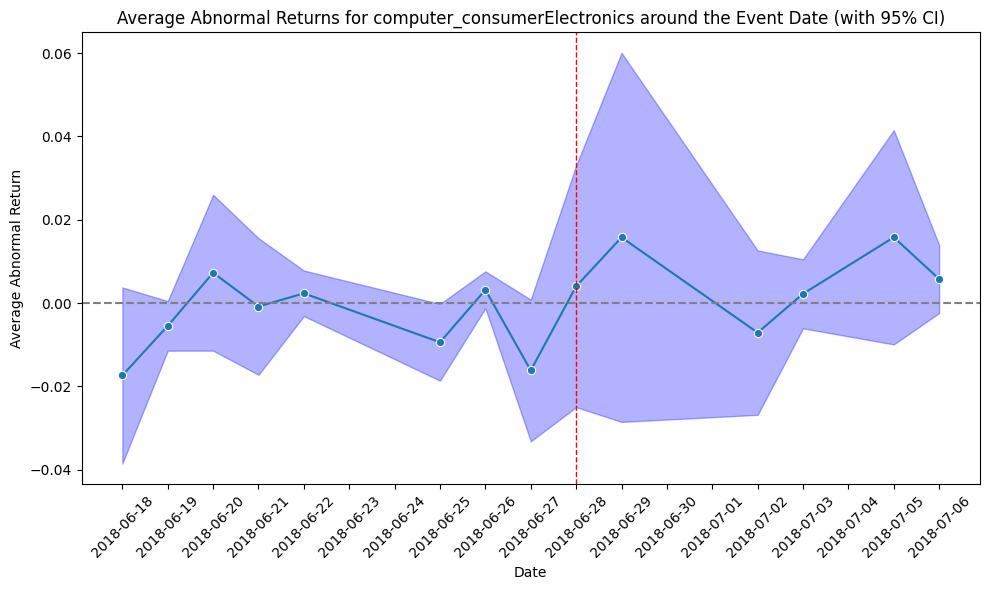

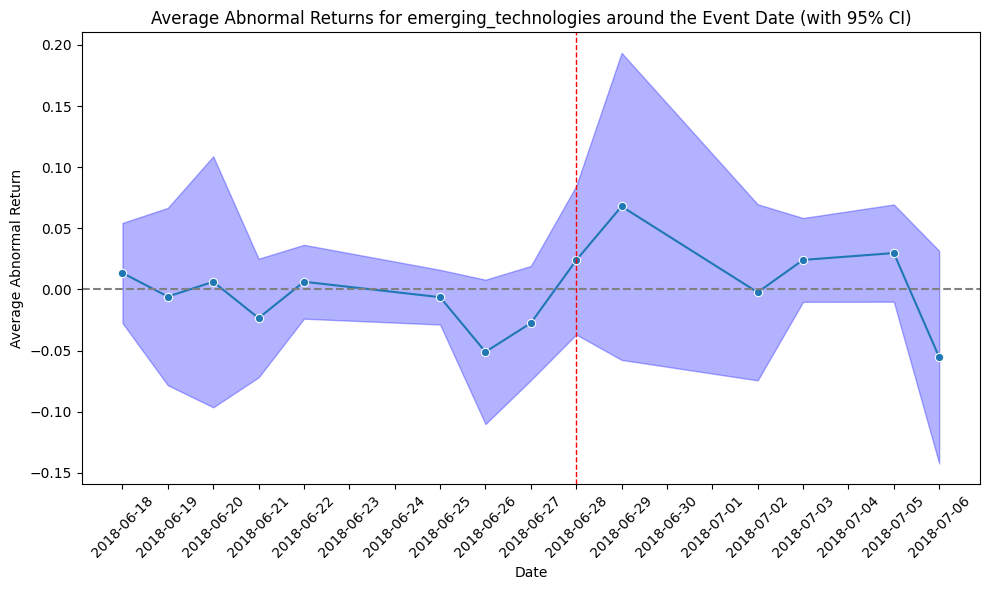

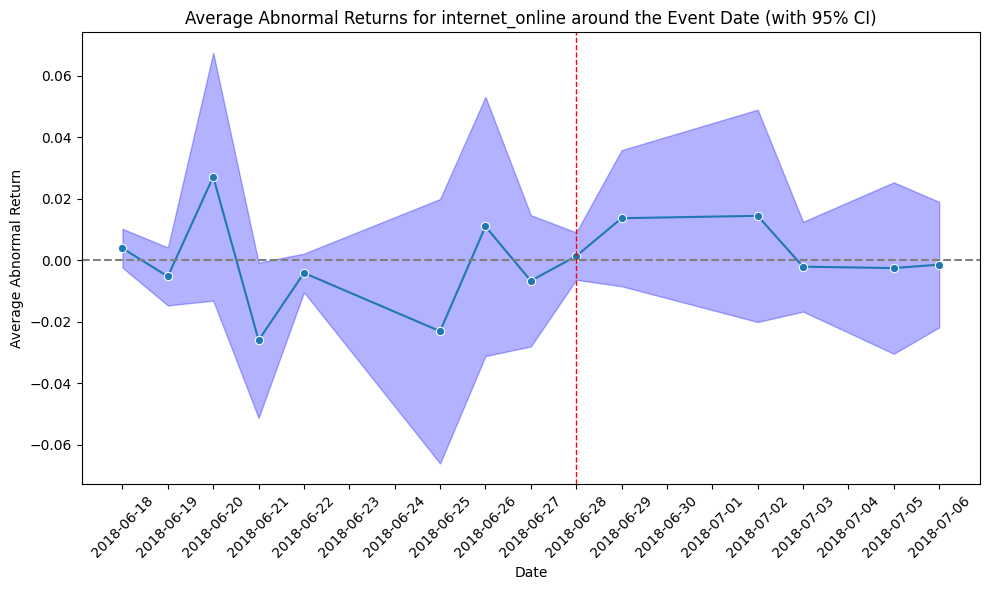

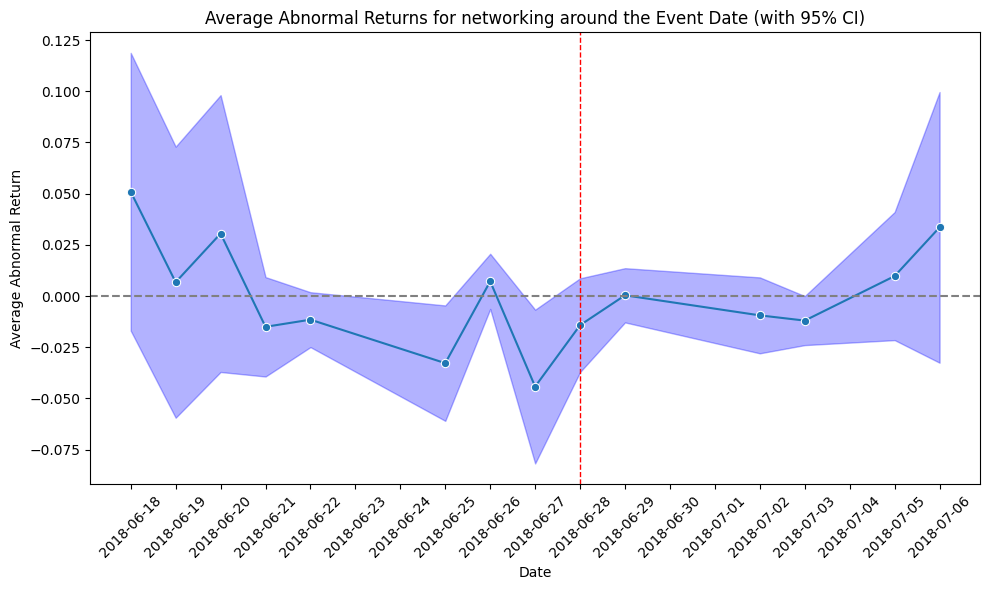

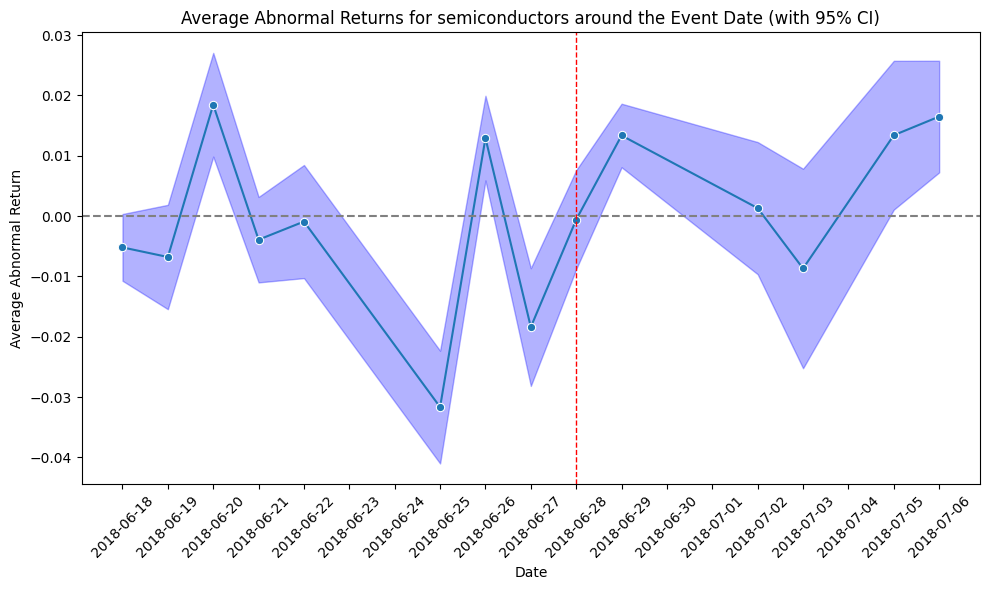

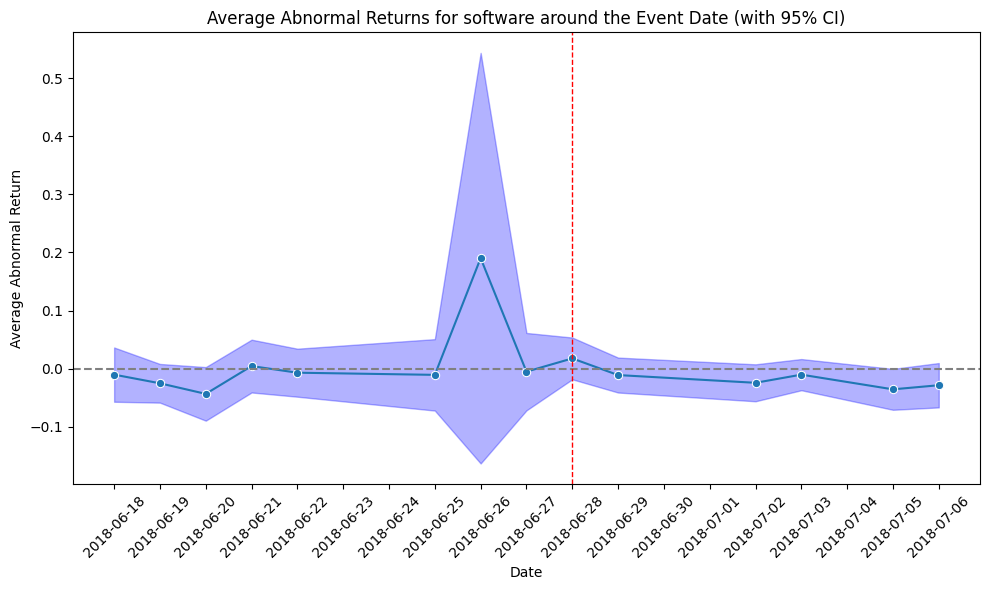

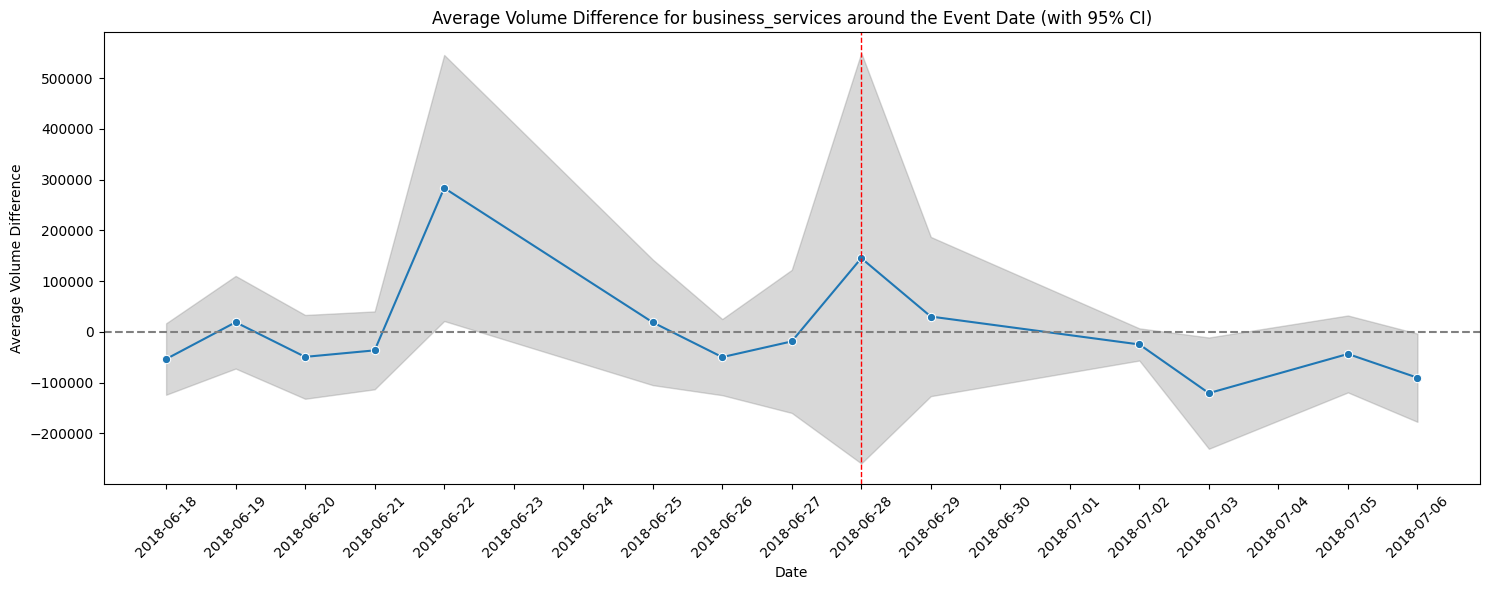

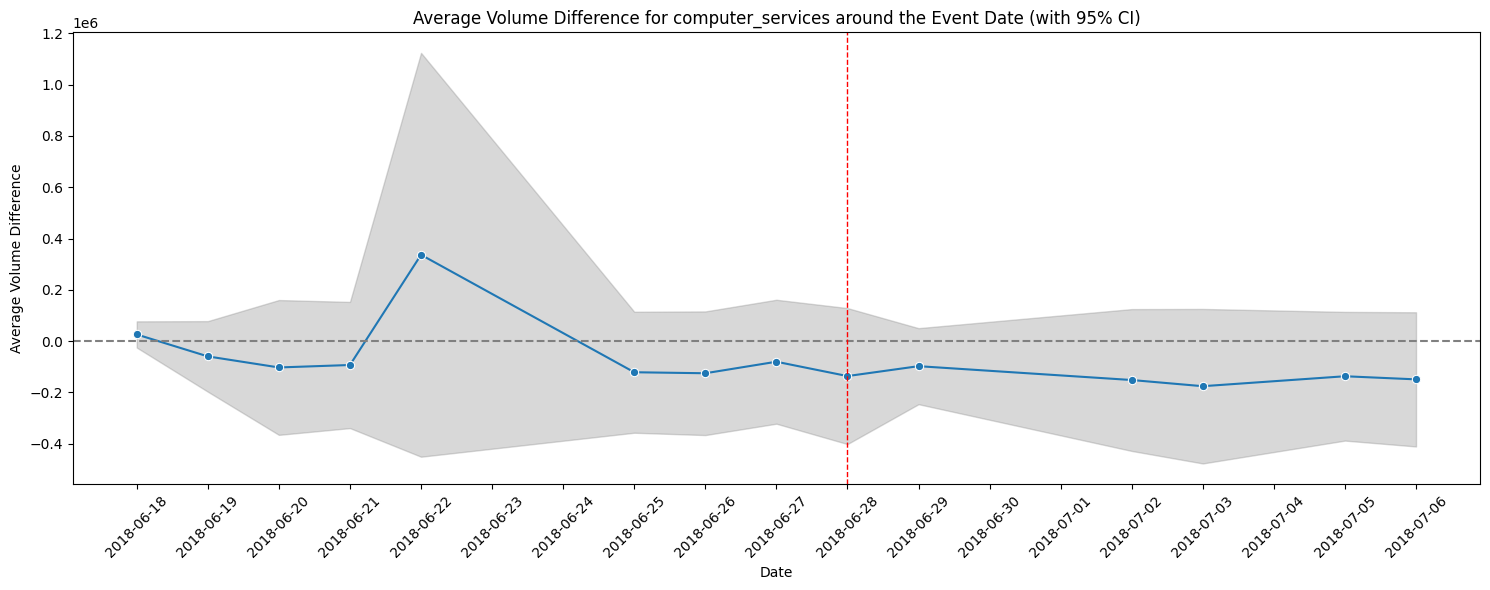

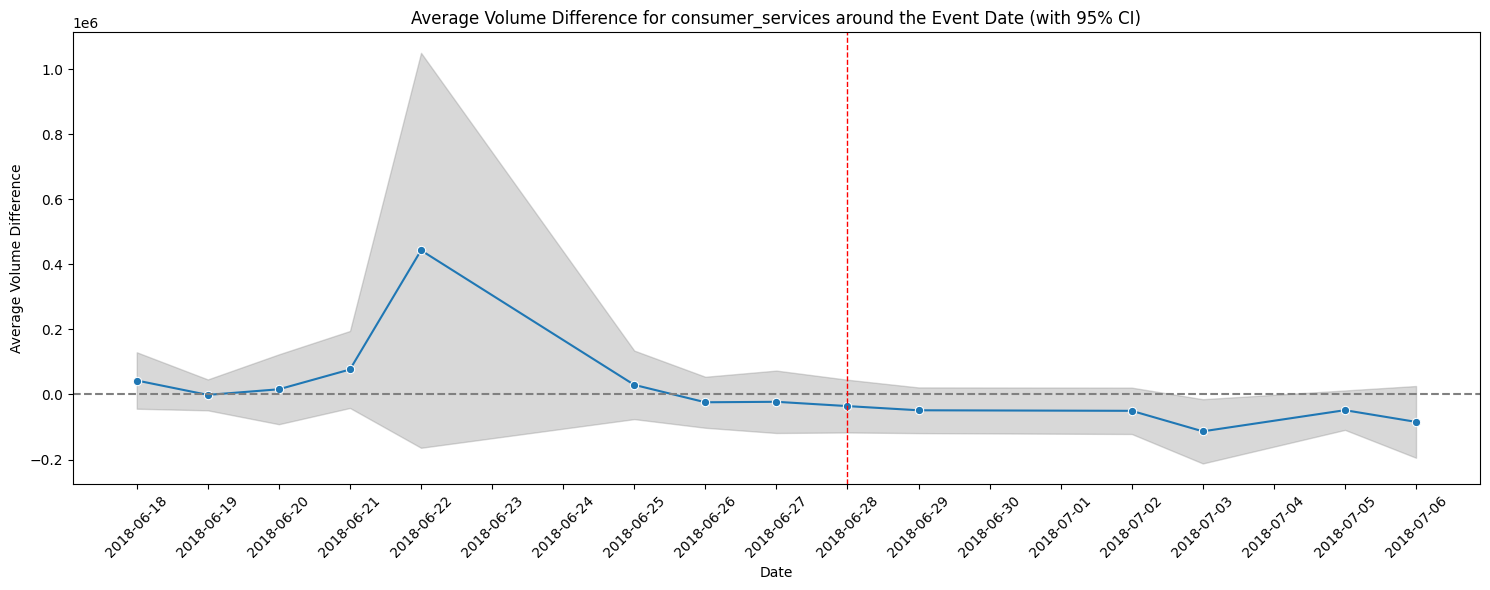

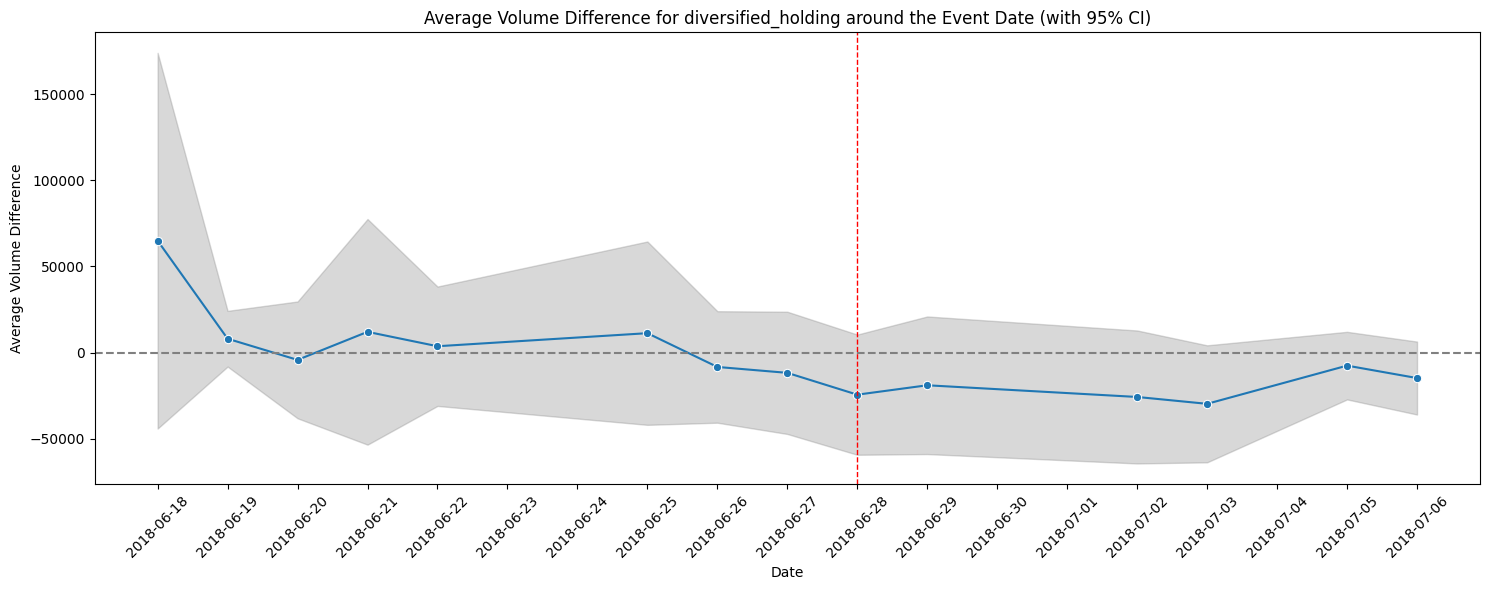

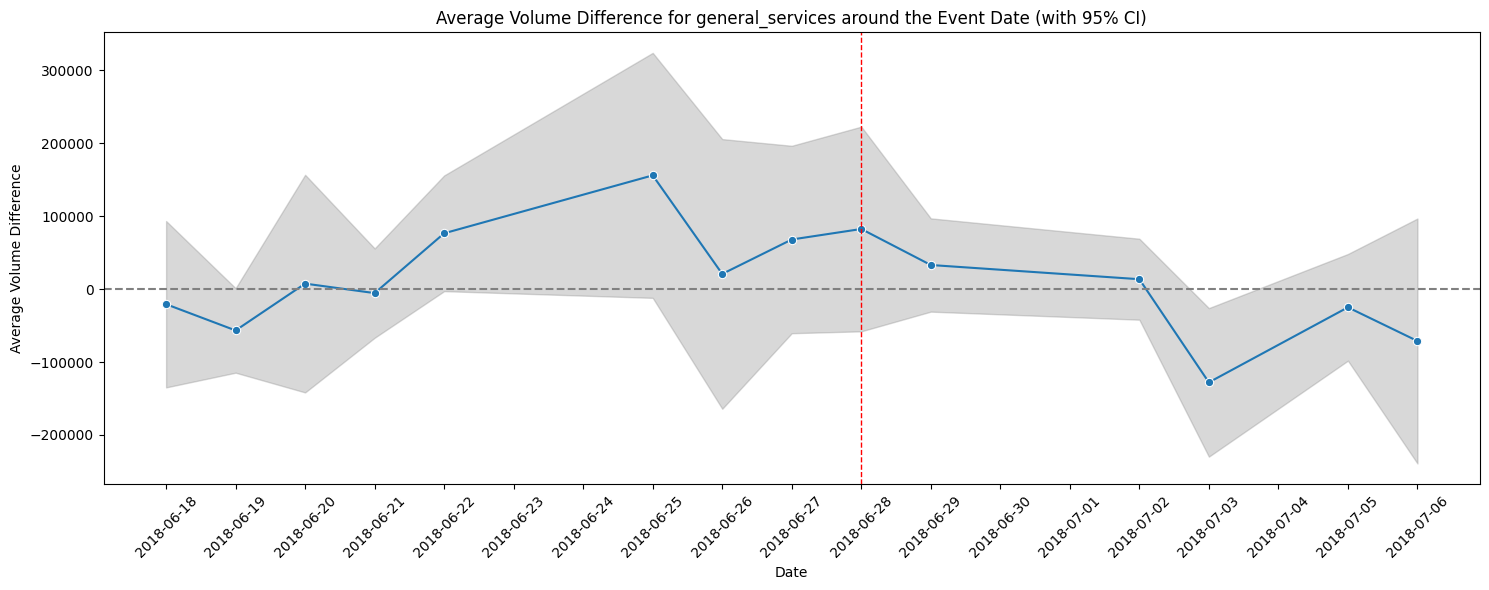

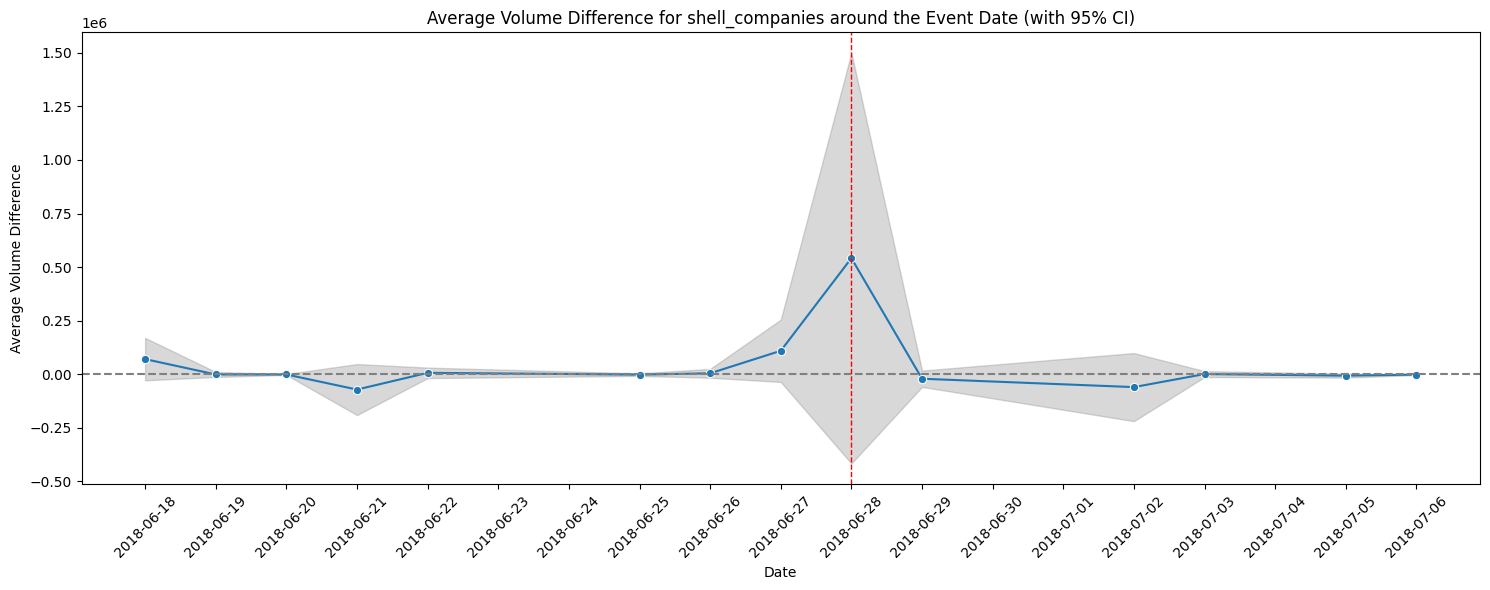

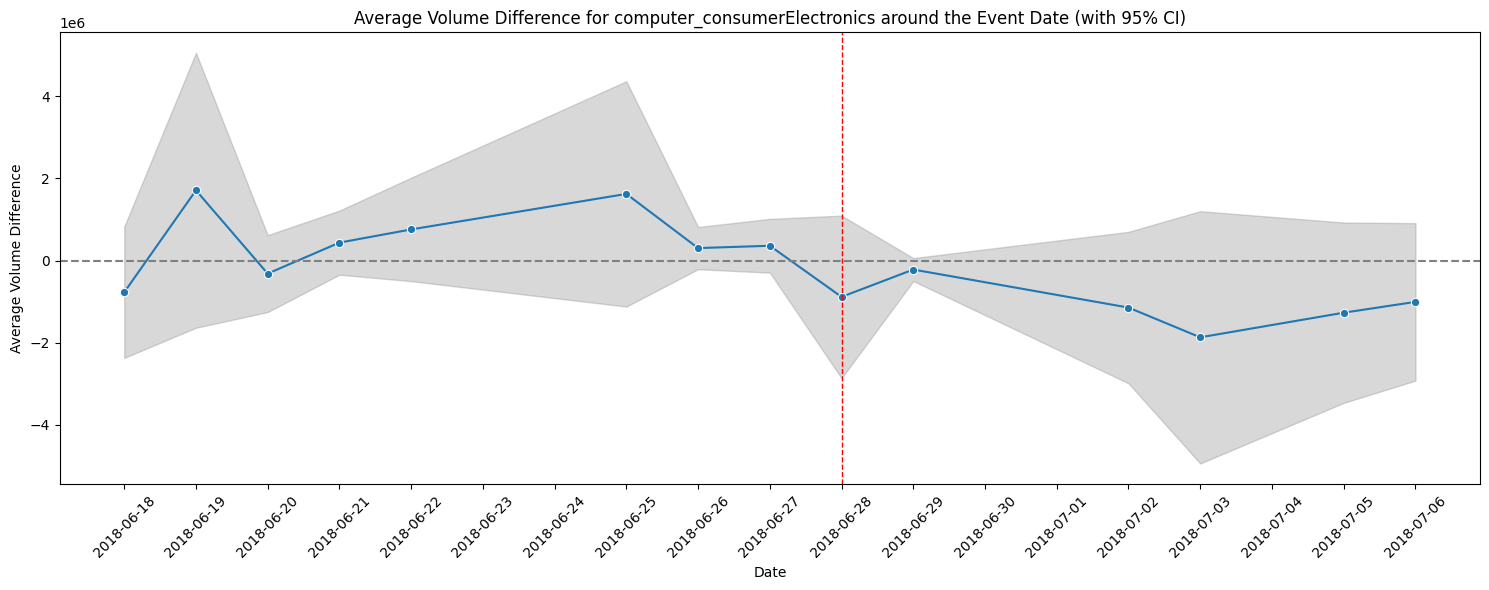

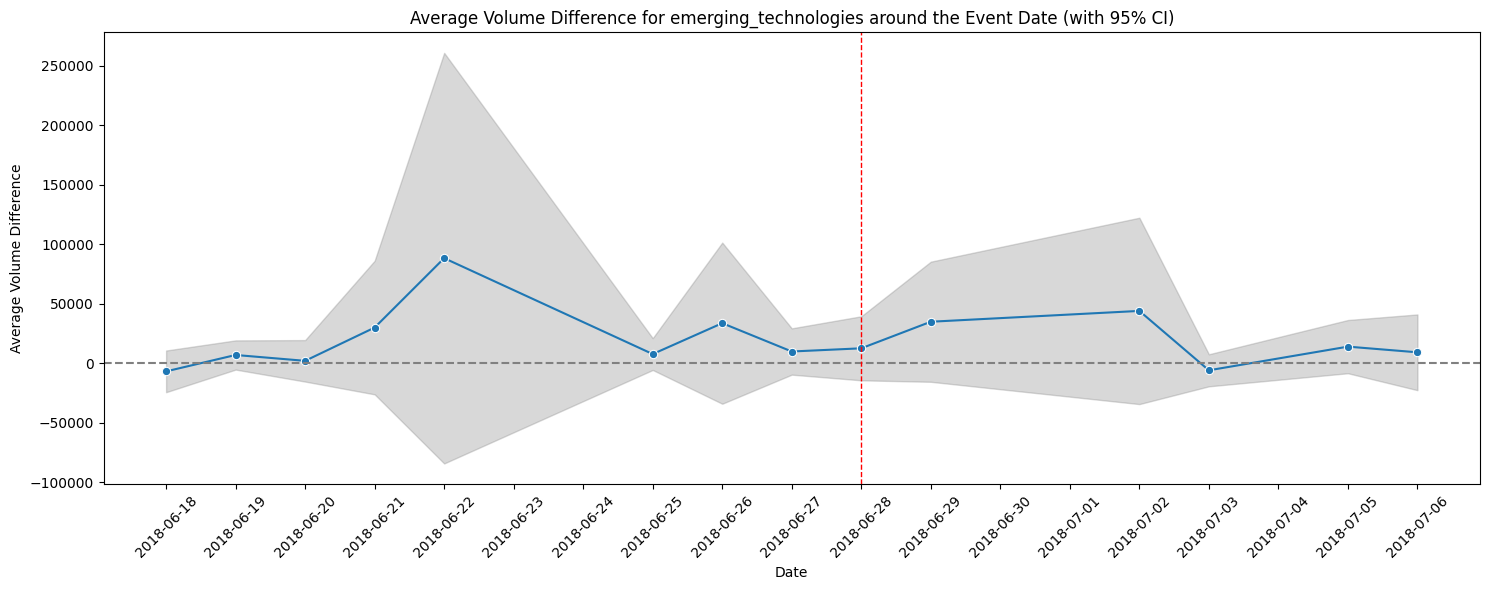

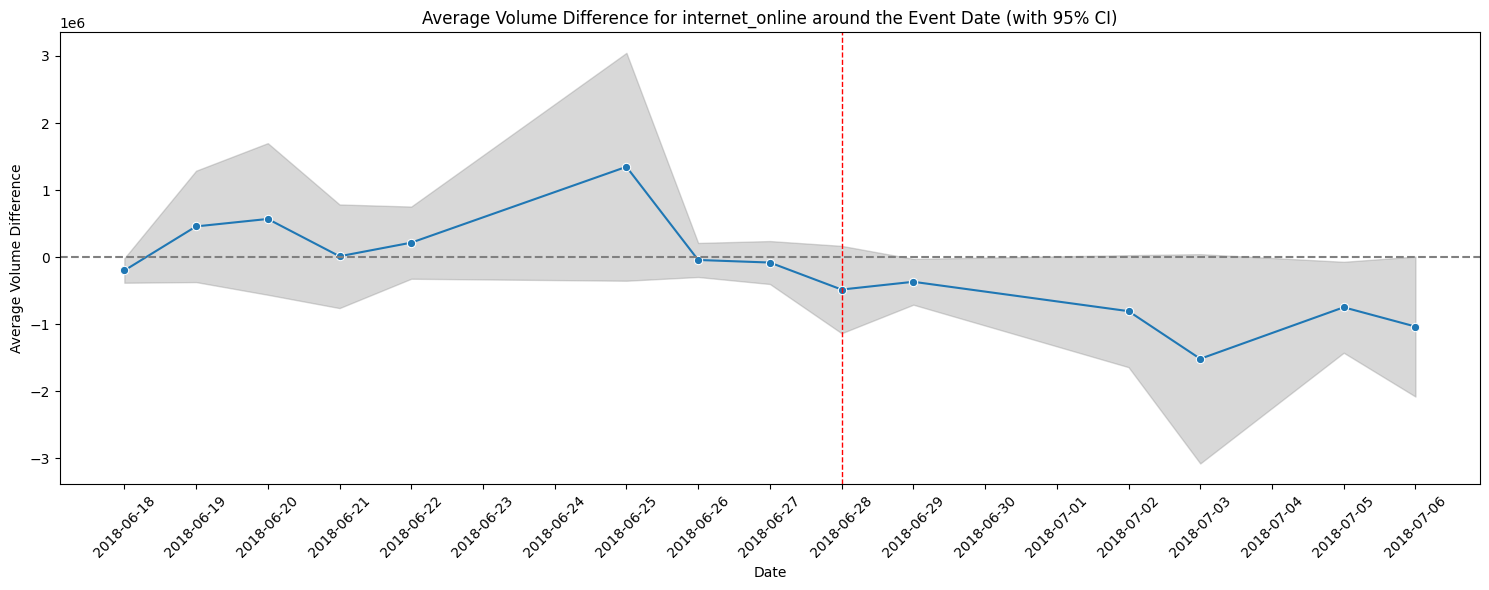

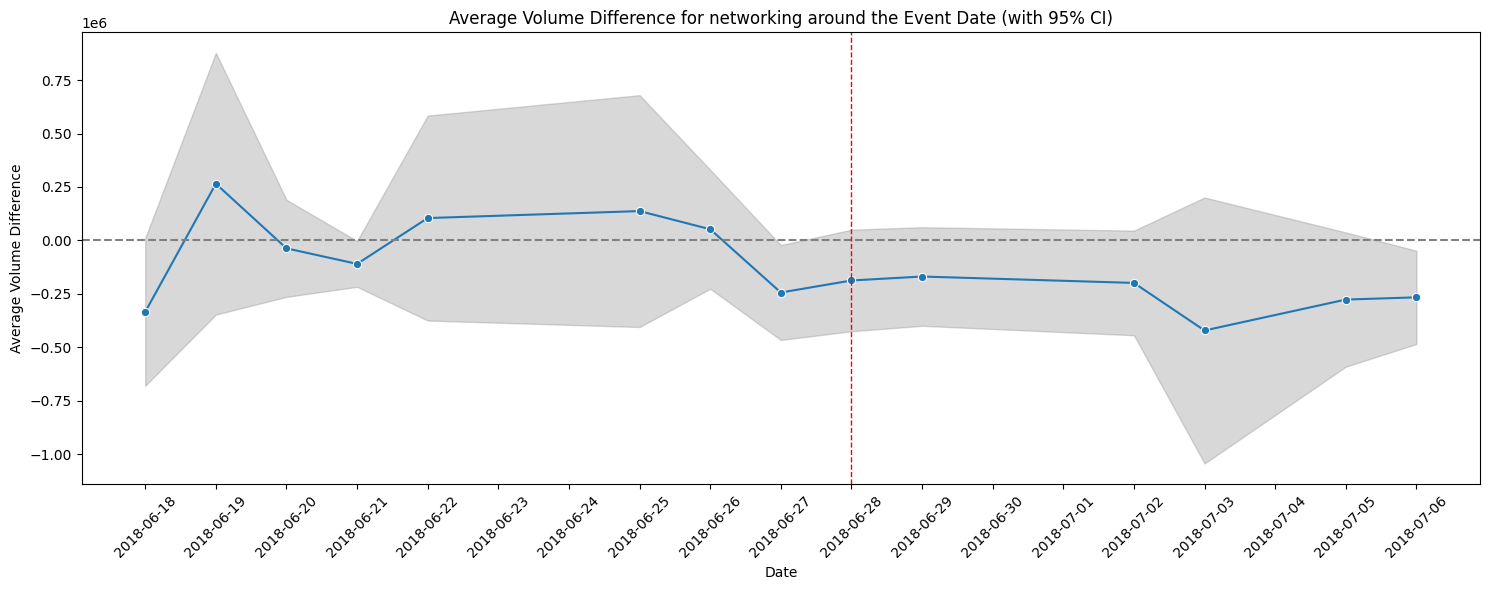

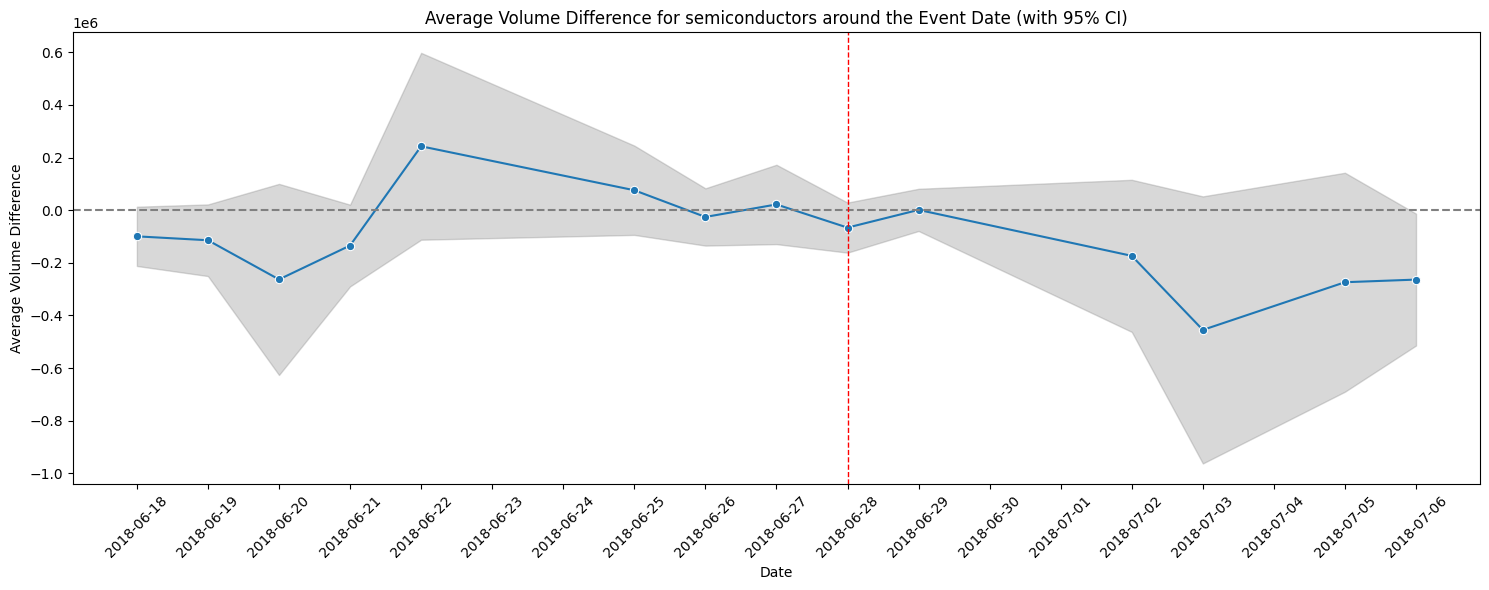

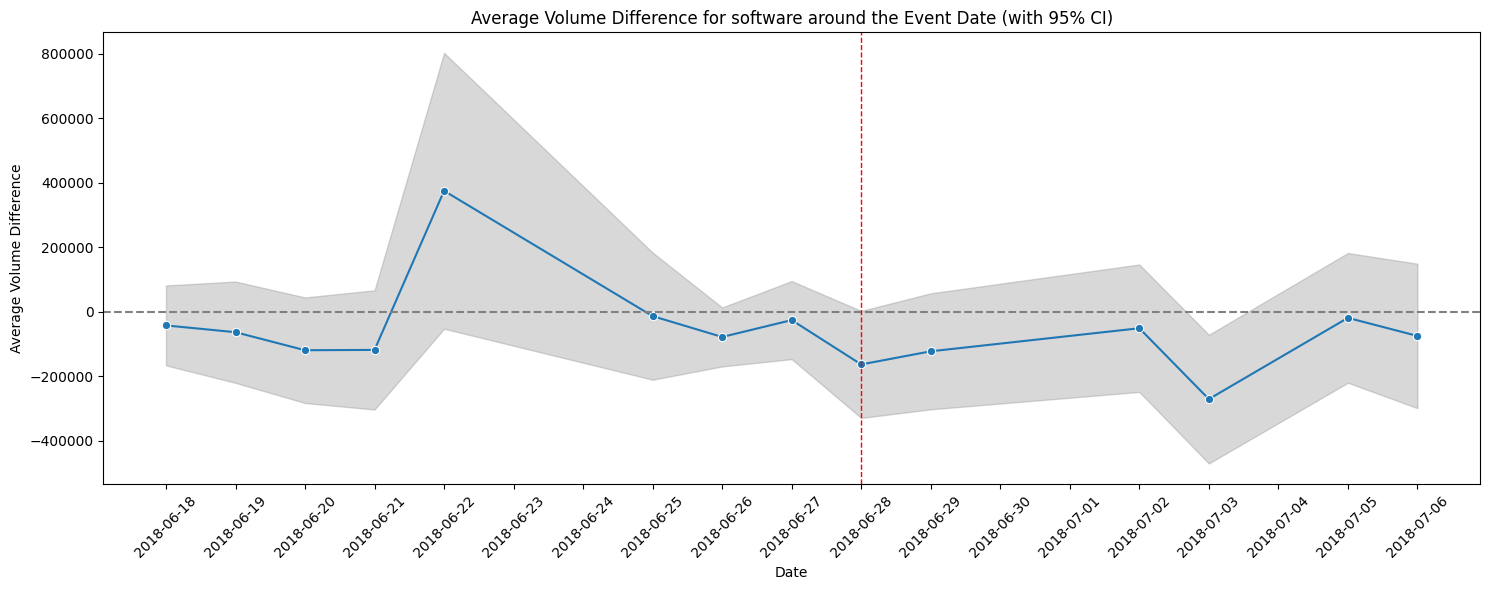

In [17]:
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
stock_data = pd.read_csv(file_path)
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Utility Functions
def calculate_stock_and_market_return(data):
    data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
    data['market_return'] = data['market_adj_close'].pct_change()
    return data

def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2: 
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params

def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  
        return np.nan
    return alpha + beta * row['market_return']

def calculate_abnormal_return(group_data, parameters):
    group_data['expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
    group_data['abnormal_return'] = group_data['stock_return'] - group_data['expected_return']
    return group_data

def calculate_volume_difference(group_data, group_estimation_data):
    average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
    group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
    group_data['volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']
    return group_data

# Main Event Study Function
def event_study(data, study_type, event_date, group_by, window_size=10, estimation_window_size=30):
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    grouped_event_data = []
    for group in data[group_by].unique():
        group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
        group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

        if group_data.empty:
            continue

        if study_type == 'price':
            parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
            group_data = calculate_abnormal_return(group_data, parameters)

        elif study_type == 'volume':
            group_data = calculate_volume_difference(group_data, group_estimation_data)

        grouped_event_data.append(group_data)

    return grouped_event_data

# Plotting Function
def plot_event_study(group_data, study_type, event_date, group_by):
    column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'
    mean_data = group_data.groupby('date')[column].mean()
    sem_data = group_data.groupby('date')[column].std() / np.sqrt(group_data.groupby('date')[column].count())
    ci = 1.96 * sem_data

    mean_data = mean_data.to_frame('mean')
    mean_data['lower_ci'] = mean_data['mean'] - ci
    mean_data['upper_ci'] = mean_data['mean'] + ci

    plt.figure(figsize=(15, 6) if study_type == 'volume' else (10, 6))
    plt.fill_between(mean_data.index, mean_data['lower_ci'], mean_data['upper_ci'], color='gray' if study_type == 'volume' else 'blue', alpha=0.3)
    sns.lineplot(data=mean_data, x=mean_data.index, y='mean', marker='o')
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(mdates.date2num(event_date), color='red', lw=1, ls='--')
    plt.title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} for {group_data[group_by].iloc[0]} around the Event Date (with 95% CI)')
    plt.xlabel('Date')
    plt.ylabel('Average ' + ('Abnormal Return' if study_type == 'price' else 'Volume Difference'))
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.tight_layout()
    plt.show()

# Perform Event Study
event_date = datetime(2018, 6, 28)
group_by = 'industry'

stock_data = calculate_stock_and_market_return(stock_data)

grouped_price_event_data = event_study(stock_data, 'price', event_date, group_by)
for group_data in grouped_price_event_data:
    plot_event_study(group_data, 'price', event_date, group_by)

grouped_volume_event_data = event_study(stock_data, 'volume', event_date, group_by)
for group_data in grouped_volume_event_data:
    plot_event_study(group_data, 'volume', event_date, group_by)

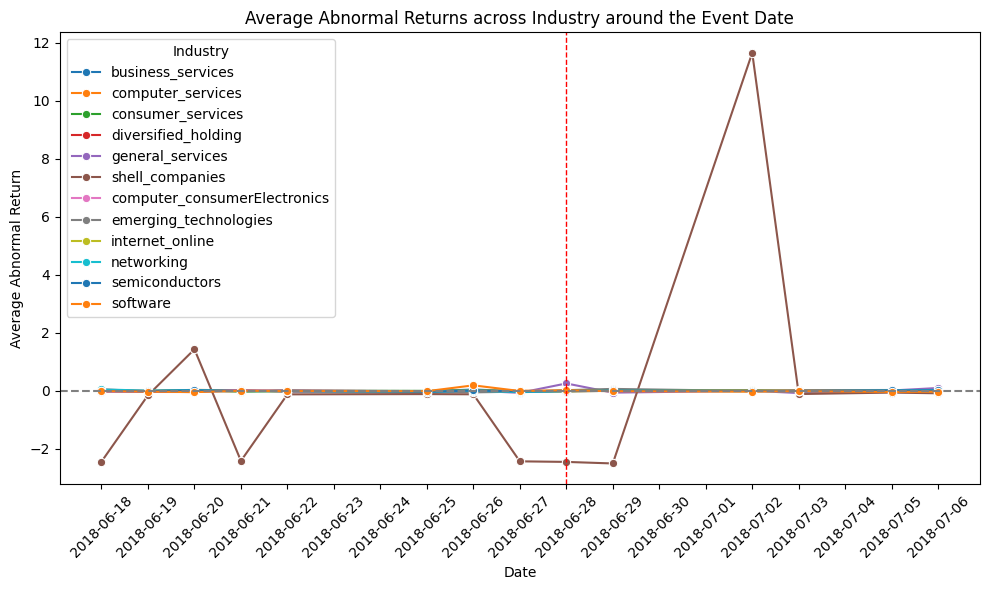

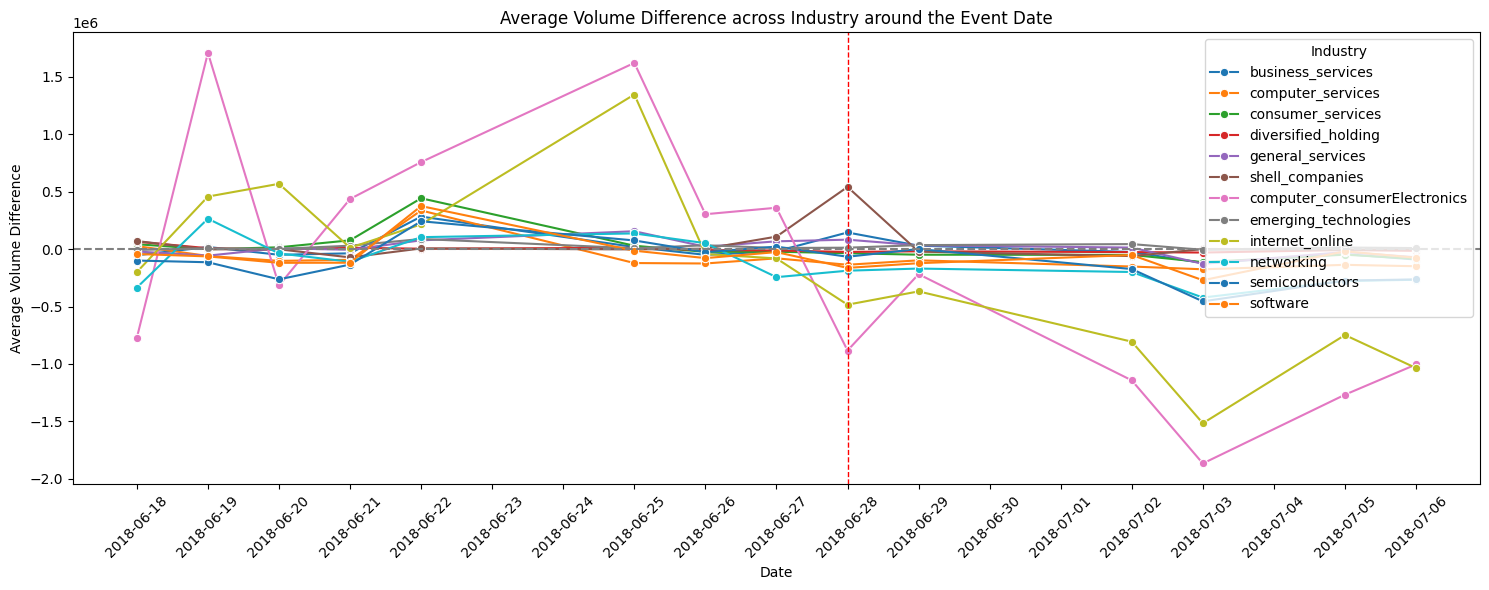

In [42]:


# Load and prepare data
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
stock_data = pd.read_csv(file_path)
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Utility Functions
def calculate_stock_and_market_return(data):
    data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
    data['market_return'] = data['market_adj_close'].pct_change()
    return data

def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2: 
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params

def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  
        return np.nan
    return alpha + beta * row['market_return']

def calculate_abnormal_return(group_data, parameters):
    group_data['expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
    group_data['abnormal_return'] = group_data['stock_return'] - group_data['expected_return']
    return group_data

def calculate_volume_difference(group_data, group_estimation_data):
    average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
    group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
    group_data['volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']
    return group_data

# Main Event Study Function
def event_study(data, study_type, event_date, group_by, window_size=10, estimation_window_size=30):
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    grouped_event_data = {}
    for group in data[group_by].unique():
        group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
        group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

        if group_data.empty:
            continue

        if study_type == 'price':
            parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
            group_data = calculate_abnormal_return(group_data, parameters)

        elif study_type == 'volume':
            group_data = calculate_volume_difference(group_data, group_estimation_data)

        grouped_event_data[group] = group_data

    return grouped_event_data


def plot_event_study(grouped_data, study_type, event_date, group_by):
    column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'
    plt.figure(figsize=(15, 6) if study_type == 'volume' else (10, 6))
    
    for group, group_data in grouped_data.items():
        mean_data = group_data.groupby('date')[column].mean()
        mean_data = mean_data.to_frame('mean')  # Convert to DataFrame
        mean_data['date'] = mean_data.index  # Add 'date' as a column for x-axis

        # Plot the mean without confidence interval
        sns.lineplot(data=mean_data, x='date', y='mean', marker='o', label=group)

    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(mdates.date2num(event_date), color='red', lw=1, ls='--')
    plt.title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} across {group_by.capitalize()} around the Event Date')
    plt.xlabel('Date')
    plt.ylabel('Average ' + ('Abnormal Return' if study_type == 'price' else 'Volume Difference'))
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.legend(title=group_by.capitalize())
    plt.tight_layout()
    plt.show()

# Perform Event Study and Plot
event_date = datetime(2018, 6, 28)
group_by = 'industry'

stock_data = calculate_stock_and_market_return(stock_data)

grouped_price_event_data = event_study(stock_data, 'price', event_date, group_by)
plot_event_study(grouped_price_event_data, 'price', event_date, group_by)

grouped_volume_event_data = event_study(stock_data, 'volume', event_date, group_by)
plot_event_study(grouped_volume_event_data, 'volume', event_date, group_by)


In [39]:


# Load and prepare data
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
stock_data = pd.read_csv(file_path)
stock_data['date'] = pd.to_datetime(stock_data['date'])

# Utility Functions
def calculate_stock_and_market_return(data):
    data['stock_return'] = data.groupby('ticker')['stock_adj_close'].pct_change()
    data['market_return'] = data['market_adj_close'].pct_change()
    return data

def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2: 
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params

def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  
        return np.nan
    return alpha + beta * row['market_return']

def calculate_abnormal_return(group_data, parameters):
    group_data['expected_return'] = group_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
    group_data['abnormal_return'] = group_data['stock_return'] - group_data['expected_return']
    return group_data

def calculate_volume_difference(group_data, group_estimation_data):
    average_volume_estimation = group_estimation_data.groupby('ticker')['stock_volume'].mean()
    group_data = group_data.join(average_volume_estimation, on='ticker', rsuffix='_avg')
    group_data['volume_difference'] = group_data['stock_volume'] - group_data['stock_volume_avg']
    return group_data

# Main Event Study Function
def event_study(data, study_type, event_date, group_by=None, window_size=10, estimation_window_size=30):
    """
    Performs an event study for either stock price or stock volume.
    Optionally groups data based on 'group_by' column.
    """

    # Convert 'date' column to datetime once for efficiency
    data['date'] = pd.to_datetime(data['date'])

    # Define the event and estimation windows
    start_date = event_date - timedelta(days=window_size)
    end_date = event_date + timedelta(days=window_size)
    estimation_start_date = start_date - timedelta(days=estimation_window_size)
    estimation_end_date = start_date - timedelta(days=1)

    if group_by and group_by in data.columns:
        # Perform event study grouped by the specified column
        grouped_event_data = {}
        for group in data[group_by].unique():
            group_data = data[(data['date'] >= start_date) & (data['date'] <= end_date) & (data[group_by] == group)].copy()
            group_estimation_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date) & (data[group_by] == group)].copy()

            if study_type == 'price':
                parameters = {ticker: estimate_parameters(ticker, group_data) for ticker in group_data['ticker'].unique()}
                group_data = calculate_abnormal_return(group_data, parameters)

            elif study_type == 'volume':
                group_data = calculate_volume_difference(group_data, group_estimation_data)

            grouped_event_data[group] = group_data

        return grouped_event_data

    else:
        # Perform event study without grouping
        event_window_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].copy()
        estimation_window_data = data[(data['date'] >= estimation_start_date) & (data['date'] <= estimation_end_date)].copy()

        if study_type == 'price':
            # Code for price study
            pass  # Same as in your first snippet

        elif study_type == 'volume':
            # Code for volume study
            pass  # Same as in your first snippet

        return event_window_data

# Modified Plotting Function
def plot_event_study(grouped_data, study_type, event_date, group_by):
    column = 'volume_difference' if study_type == 'volume' else 'abnormal_return'
    plt.figure(figsize=(15, 6) if study_type == 'volume' else (10, 6))
    
    for group, group_data in grouped_data.items():
        mean_data = group_data.groupby('date')[column].mean()
        sem_data = group_data.groupby('date')[column].std() / np.sqrt(group_data.groupby('date')[column].count())
        ci = 1.96 * sem_data

        mean_data = mean_data.to_frame('mean')
        mean_data['lower_ci'] = mean_data['mean'] - ci
        mean_data['upper_ci'] = mean_data['mean'] + ci

        plt.fill_between(mean_data.index, mean_data['lower_ci'], mean_data['upper_ci'], alpha=0.3)
        plt.plot(mean_data.index, mean_data['mean'], marker='o', label=group)

    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(mdates.date2num(event_date), color='red', lw=1, ls='--')
    plt.title(f'Average {("Abnormal Returns" if study_type == "price" else "Volume Difference")} across {group_by.capitalize()} around the Event Date (with 95% CI)')
    plt.xlabel('Date')
    plt.ylabel('Average ' + ('Abnormal Return' if study_type == 'price' else 'Volume Difference'))
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.legend(title=group_by.capitalize())
    plt.tight_layout()
    plt.show()


event_date = datetime(2018, 6, 28)
group_by = None  # Set group_by to None for no grouping

stock_data = calculate_stock_and_market_return(stock_data)

price_event_data = event_study(stock_data, 'price', event_date, group_by)
plot_event_study(price_event_data, 'price', event_date, group_by)

volume_event_data = event_study(stock_data, 'volume', event_date, group_by)
plot_event_study(volume_event_data, 'volume', event_date, group_by)

KeyError: 'date'

<Figure size 1000x600 with 0 Axes>